In [1]:
# direct to proper path
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import numpy as np
from ipywidgets import IntProgress
from IPython.display import display
import matplotlib.pyplot as plt
from collections import defaultdict
import seaborn as sns
import pickle
from prettytable import PrettyTable

from codes.BAI_FixedBudget import *
from codes.Environment import Mixture_AbsGau, setup_env, Exp
from codes.SimulatedGames import simulate
from codes.plots import *

%matplotlib inline

In [2]:
rewards_array = np.load('rewards.npy')

# rewards_array = np.delete(rewards_array_raw, (23,11), axis=0)

In [3]:
class Vaccine_Env():
    """Env for Exponential Distribution.
    """
    def __init__(self, reward):
        self.reward = reward

    def sample(self, size = None):
        return np.random.choice(self.reward)

    def est_hazard_rate(self,bandwidth = 0.005):
        sorted_reward = np.sort(self.reward)
        x_list = np.arange(sorted_reward[0], sorted_reward[-1], 0.01)
        est_h_list = []
        for i, x in enumerate(x_list):
            count1 = 0
            count2 = 0
            for reward in sorted_reward:
                if x <= reward <= x + bandwidth:
                    count1 +=1
                if x<= reward:
                    count2+=1
            est_h = count1/count2/bandwidth
            est_h_list.append(est_h)

        plt.scatter(x_list, est_h_list)

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


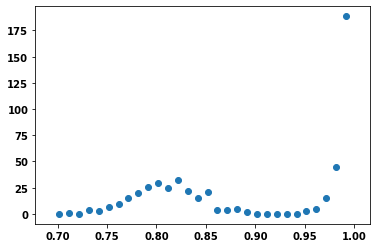

In [4]:
Vaccine_Env(rewards_array[10]).est_hazard_rate()

In [5]:
def setup_env(rewards_array, ss_list = ['quantile_0.5'], random_set = None):
    """Setup environment for Vaccine simulations.
    """
    
    rewards_env = defaultdict(list)
    true_ss_dict = {}

    name = 'vaccine'
    true_ss_dict[name] = defaultdict(list)

    for arm_no, reward in enumerate(rewards_array):
        
        current_env = Vaccine_Env(reward)
                
        rewards_env[name].append(current_env)
                
        for ss in ss_list:
            ss_name = ss.split('_')[0]
            if len(ss.split('_'))> 1:
                ss_para = float(ss.split('_')[-1])
            if ss_name == 'quantile':
                true_ss_dict[name][ss].append(np.quantile(reward, ss_para))
            elif ss_name == 'mean':
                true_ss_dict[name][ss_name].append(np.mean(reward))
            else:
                assert True, 'Unknown summary statistics!'

    return rewards_env, true_ss_dict

0
median:  0.7854999999999999
mean:  0.7680238925100001
1
median:  0.793207
mean:  0.77564602245
2
median:  0.8036784
mean:  0.78803469408
3
median:  0.8041
mean:  0.78773167958
4
median:  0.8016792
mean:  0.78882768705
5
median:  0.801698
mean:  0.7834913052200001
6
median:  0.8055388
mean:  0.78688506055
7
median:  0.8025
mean:  0.7874538141699999
8
median:  0.8871112000000001
mean:  0.8491823457999998
9
median:  0.8446089999999999
mean:  0.82401162935
10
median:  0.8251046
mean:  0.8081958746200001
11
median:  0.821089
mean:  0.80356375051
12
median:  0.8493408
mean:  0.8264946653199999
13
median:  0.8260000000000001
mean:  0.8084246083200001
14
median:  0.8221779999999999
mean:  0.8035054574999999
15
median:  0.816184
mean:  0.80088930968
16
median:  0.8127244
mean:  0.79764478747
17
median:  0.798621
mean:  0.78434753713
18
median:  0.8060388
mean:  0.7890701515800002
19
median:  0.8026186000000001
mean:  0.7872946434999999
20
median:  0.8075192
mean:  0.79184802109
21
median:  0.

Text(0.5, 1.0, 'Histogram')

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


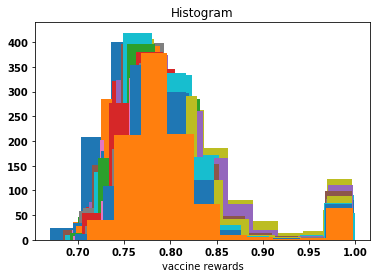

In [6]:
quantile_list = []
mean_list = []
tau = 0.8

for i, reward in enumerate(rewards_array):
    plt.hist(reward)
    quantile_list.append(np.quantile(reward, tau))
    mean_list.append(np.mean(reward))
    print(i)
    print('median: ', np.quantile(reward, tau))
    print('mean: ', np.mean(reward))
plt.xlabel('vaccine rewards')
plt.title('Histogram')

In [7]:
np.argsort(mean_list)

array([ 0,  1,  5, 17, 23, 21,  6, 19,  7,  3,  2, 22,  4, 18, 20, 16, 31,
       15, 14, 11, 30, 27, 26, 10, 13, 29, 28, 25,  9, 12, 24,  8])

In [8]:
np.argsort(quantile_list)

array([ 0,  1, 17, 21,  4,  5,  7, 19,  2, 23,  3,  6, 22, 18, 20, 16, 31,
       15, 27, 11, 30, 14, 26, 10, 13, 29, 28,  9, 25, 12, 24,  8])

In [9]:
rewards_env_mean, true_ss_dict_mean = setup_env(rewards_array, ['mean'])
rewards_env, true_ss_dict = setup_env(rewards_array, ['quantile_0.8'])

In [10]:
np.sort(true_ss_dict['vaccine']['quantile_0.8'])[::-1]

array([0.8871112, 0.8665802, 0.8493408, 0.846231 , 0.844609 , 0.8391   ,
       0.8275   , 0.826    , 0.8251046, 0.8230176, 0.822178 , 0.8221068,
       0.821089 , 0.8207432, 0.816184 , 0.8152034, 0.8127244, 0.8075192,
       0.8060388, 0.8057134, 0.8055388, 0.8041   , 0.8037156, 0.8036784,
       0.8026186, 0.8025   , 0.801698 , 0.8016792, 0.8015198, 0.798621 ,
       0.793207 , 0.7855   ])

In [11]:
def run_exper(rewards_env, summary_stats, policy, epsilon, m, budget, num_exper, fixed_samples_list = None,policy_for_mean = False):
    for key in rewards_env.keys():
        name = key + '_' + str(num_exper)
        if policy_for_mean:
                policy_name = str(policy).split('.')[-1].split('\'')[0] + '-'
                policy_name = policy_name[2:]
                # print(policy_name)
        else:
                policy_name = str(policy).split('.')[-1].split('\'')[0] + '-'

        subname = policy_name  + str(budget) 
        p = IntProgress(max = num_exper)
        p.description = 'Running'
        display(p)
        results[name][subname] = []

        result = simulate(rewards_env[key],summary_stats[key], policy, 
                epsilon, m, budget, num_exper, p, fixed_samples_list)
        results[name][subname].append(result)

In [12]:

results = defaultdict(dict)

num_exper = 500
epsilon = 0
m = 5

In [13]:
# for budget in [1000, 1250, 1500, 1750, 2000, 2250, 2500, 2750, 3000, 3250, 3500, 3750, 4000]:
for budget in [1000, 1500, 2000, 2500, 3000,  3500, 4000]:
# for budget in [500, 750, 1000, 1250, 1500, 1750, 2000, 2250, 2500]:
# for budget in [500]:
    # run_exper(rewards_env, true_ss_dict, Q_SAR_Simplified_Large_Margin, epsilon, m, budget, num_exper)

    # run_exper(rewards_env, true_ss_dict, Q_SAR, epsilon, m, budget, num_exper)
    run_exper(rewards_env, true_ss_dict, Q_SR, epsilon, m, budget, num_exper)

    run_exper(rewards_env, true_ss_dict, Q_SAR_Simplified, epsilon, m, budget, num_exper)

    # run_exper(rewards_env, true_ss_dict, OS_SAR_Simplified, epsilon, m, budget, num_exper)

    # run_exper(rewards_env, true_ss_dict, batch_elimination, epsilon, m, budget, num_exper)

    # run_exper(rewards_env, true_ss_dict, uniform_sampling, epsilon, m, budget, num_exper)

    run_exper(rewards_env_mean, true_ss_dict_mean, Q_SR, epsilon, m, budget, num_exper, policy_for_mean = True)

    run_exper(rewards_env_mean, true_ss_dict_mean, Q_SAR_Simplified, epsilon, m, budget, num_exper, policy_for_mean = True)
 

IntProgress(value=0, description='Running', max=500)

IntProgress(value=0, description='Running', max=500)

IntProgress(value=0, description='Running', max=500)

IntProgress(value=0, description='Running', max=500)

IntProgress(value=0, description='Running', max=500)

IntProgress(value=0, description='Running', max=500)

IntProgress(value=0, description='Running', max=500)

IntProgress(value=0, description='Running', max=500)

IntProgress(value=0, description='Running', max=500)

IntProgress(value=0, description='Running', max=500)

IntProgress(value=0, description='Running', max=500)

IntProgress(value=0, description='Running', max=500)

IntProgress(value=0, description='Running', max=500)

IntProgress(value=0, description='Running', max=500)

IntProgress(value=0, description='Running', max=500)

IntProgress(value=0, description='Running', max=500)

IntProgress(value=0, description='Running', max=500)

IntProgress(value=0, description='Running', max=500)

IntProgress(value=0, description='Running', max=500)

IntProgress(value=0, description='Running', max=500)

IntProgress(value=0, description='Running', max=500)

IntProgress(value=0, description='Running', max=500)

IntProgress(value=0, description='Running', max=500)

IntProgress(value=0, description='Running', max=500)

IntProgress(value=0, description='Running', max=500)

IntProgress(value=0, description='Running', max=500)

IntProgress(value=0, description='Running', max=500)

IntProgress(value=0, description='Running', max=500)

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
  Budget  Probability of Error       std Policy
0   1000                 0.726  0.044601   Q-SR
1   1000                 0.942  0.023374  Q-SAR
2   1000                 0.736  0.044080     SR
3   1000                 0.726  0.044601    SAR
4   1500                 0.630  0.048280   Q-SR


,Budget,Probability of Error,std,Policy
0,1000,0.726,0.044601,Q-SR
1,1000,0.942,0.023374,Q-SAR
2,1000,0.736,0.044080,SR
3,1000,0.726,0.044601,SAR
4,1500,0.630,0.048280,Q-SR
5,1500,0.874,0.033185,Q-SAR
6,1500,0.660,0.047371,SR
7,1500,0.626,0.048386,SAR
8,2000,0.576,0.049419,Q-SR
9,2000,0.766,0.042337,Q-SAR


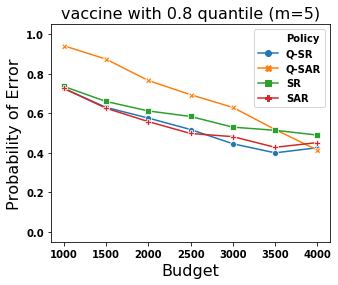

In [14]:
# save results

# with open('../vaccine_m1_05quant_budget_2000.pickle', 'wb') as handle:
#      pickle.dump(results, handle, protocol=pickle.HIGHEST_PROTOCOL)

# with open('../Group_One_Fixed_Budget.pickle', 'rb') as handle:
#     results = pickle.load(handle)

plot_eva_budget(results, 'pe', paper_flag = True, with_para = True, title = 'vaccine with 0.8 quantile (m=5)', log_scale = False)